# TP4 : Techniques avancées

Dans ce TP, vous allez mettre en pratique tout ce que vous avez appris !

Ce TP sera **À RENDRE** sur Moodle :
- Fichier notebook (`tp4.ipynb`) complété avec vos réponses
- Fichier `models_results.csv` détaillant les résultats de vos expérimentations (voir Exercice 1, Q5 et Q6)
- Fichier `predictions.csv` contenant les prédictions de votre meilleur modèle sur les données d'utilisation (voir Exercice 1, Q7)

Il comptera pour **5 points** dans votre note de TP de l'UE, principalement déterminé en fonction du F2-score de vos prédictions sur les données d'utilisation (dont vous n'aurez pas les labels...).
Exemple : vous obtenez un F2-score de 0.68 sur les données d'utilisation, vous obtiendrez $0.68 * 5 = 3.4$ points.

Le prof reste souverain et s'autorise à baisser ou invalider la note si votre fichier notebook (`tp4.ipynb`) contient de la triche et/ou ne correspond pas aux résultats que vous fournissez ! Soyez donc honnête :-)

Dans la limite de l'utilisation des données **de "prototypage"** fournies, vous êtes autorisés à utiliser toutes les techniques vues en cours : encodages, normalisations, équilibrages, suppression ou remplacement des données manquantes, ...

Les données dites "de déploiement" (ou d'utilisation) doivent être considérées comme inaccessibles : vous ne devrez les utiliser que pour faire vos prédictions finales. Comme si vous les receviez une fois votre modèle de ML entraîné et déployé sur un serveur.

Dans ce TP, on se place dans la situation de *data scientists* dans un hôpital. Vos collègues médecins essaient de détecter la présence d'une maladie cardiaque à partir de données sur les patients, obtenues par divers examens médicaux.

Votre responsable hiérarchique veut que vous entraîniez un modèle de ML qui sera capable de prédire la présence de cette maladie, afin d'accélérer le traitement des patients et d'éviter le recours à des examens complémentaires beaucoup plus coûteux.

On veut donc identifier le plus possible de patients malades (= maximiser le rappel !) pour laisser mourir le moins de patients possibles, tout en évitant de prédire les patients sains comme malade (= éviter que la précision ne soit de 0 !), sinon cela prendra trop de temps et coûtera trop cher... Nous utiliserons donc un F2-score comme métrique principale de sélection du meilleur modèle. Les autres métriques seront calculées et mémorisées à titre indicatif.

Description des données :

| Nom | Description |
|-----|-------------|
| age | Âge du patient en années |
| sex | Sexe du patient (`male` / `female`) |
| chest pain | Type de douleur dans la poitrine ressentie |
| resting blood pressure (mm Hg) | Pression sanguine au repos |
| cholestoral (mg/dl) | Taux de choléstérol dans le sang |
| fasting blood sugar > 120 mg/dl | Est-ce que le taux de glucose dans le sang après 8h à jeûn dépasse une valeur normale ? |
| resting electrocardiograph | Présence d'une anomalie à l'électrocardiographe (ECG) au repos (`normal` : pas d'anomalie, `abnormal` : anomalie ST-T, `hypertrophy` : probable hypertrophie du ventricule gauche) |
| max heart rate | Nombre maximum de battements cardiaques par minutes durant un exercice de résistance à l'effort (ex : vélo) |
| exercise induced angina | Est-ce que l'exercice de résistance à l'effort a entraîné une douleur à la poitrine ? |
| oldpeak | Dépression du segment ST de l'ECG lors de l'exercice de résistance à l'effort (relativement à l'ECG au repos) |
| slope | Forme du segment ST de l'ECG (`upsloping` : hausse, `flat` : plat, `downsloping` : baisse) |
| number of colored vessels by fluoroscopy | Le nombre d'artères majeures colorées par fluoroscopie (rayons X ou CT-scan) |
| thalassemia | Présence d'une maladie sanguine (`3` : normal, `6` : maladie irréversible, `7` : maladie réversible)
| **class** | **Cible de prédiction** : présence (`disease`) ou absence (`no disease`) d'un problème cardiaque |

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## Exercice 1 - Prise en main des données et préparation des fichiers de réponses

J'attends un certain format dans vos fichiers de réponses (`models_results.csv` et `predictions.csv`) ; cet exercice va vous faire implémenter les fonctions permettant de remplir ces fichiers comme attendu.

Comme vu dans le CM4, lorsque l'on prototype et expérimente sur divers algorithmes de ML, il est important de retenir les scores obtenus pour chaque algorithme, chaque préparation de données, et chaque *seed* (graine aléatoire). Cela permettra de sélectionner le meilleur modèle une fois les expérimentations effectuées.

Q1. Chargez le fichier `data_prototyping.csv` dans un *DataFrame* `df`.

In [174]:
from pandas import isna


df = pd.read_csv('data_prototyping.csv', na_values=['?'])

Q2. Faites une EDA minimale : quelles sont les colonnes, quels sont leurs types de données ? Quelles sont les valeurs uniques pour chaque colonne catégorielle ? Existe-t-il des valeurs manquantes ?

Vous ferez une EDA plus poussée dans l'Exercice 2.

In [175]:
df.shape

(459, 14)

In [176]:
df.describe()

,age,resting blood pressure (mm Hg),cholestoral (mg/dl),max heart rate,oldpeak,number of colored vessels by fluoroscopy,thalassemia
count,459.000000,434.000000,437.00000,434.000000,432.000000,175.000000,206.000000
mean,51.856209,131.456221,220.06865,144.163594,0.583333,0.422857,4.485437
std,9.438205,17.986373,87.72107,25.495432,0.883334,0.783114,1.868162
min,28.000000,94.000000,0.00000,67.000000,-1.500000,0.000000,3.000000
25%,44.500000,120.000000,197.00000,125.000000,0.000000,0.000000,3.000000
50%,52.000000,130.000000,228.00000,148.000000,0.000000,0.000000,3.000000
75%,58.000000,140.000000,269.00000,163.000000,1.000000,1.000000,7.000000
max,76.000000,200.000000,564.00000,194.000000,4.200000,3.000000,7.000000


In [177]:
df.dtypes

age                                           int64
sex                                          object
chest pain                                   object
resting blood pressure (mm Hg)              float64
cholestoral (mg/dl)                         float64
fasting blood sugar > 120 mg/dl              object
resting electrocardiograph                   object
max heart rate                              float64
exercise induced angina                      object
oldpeak                                     float64
slope                                        object
number of colored vessels by fluoroscopy    float64
thalassemia                                 float64
class                                        object
dtype: object

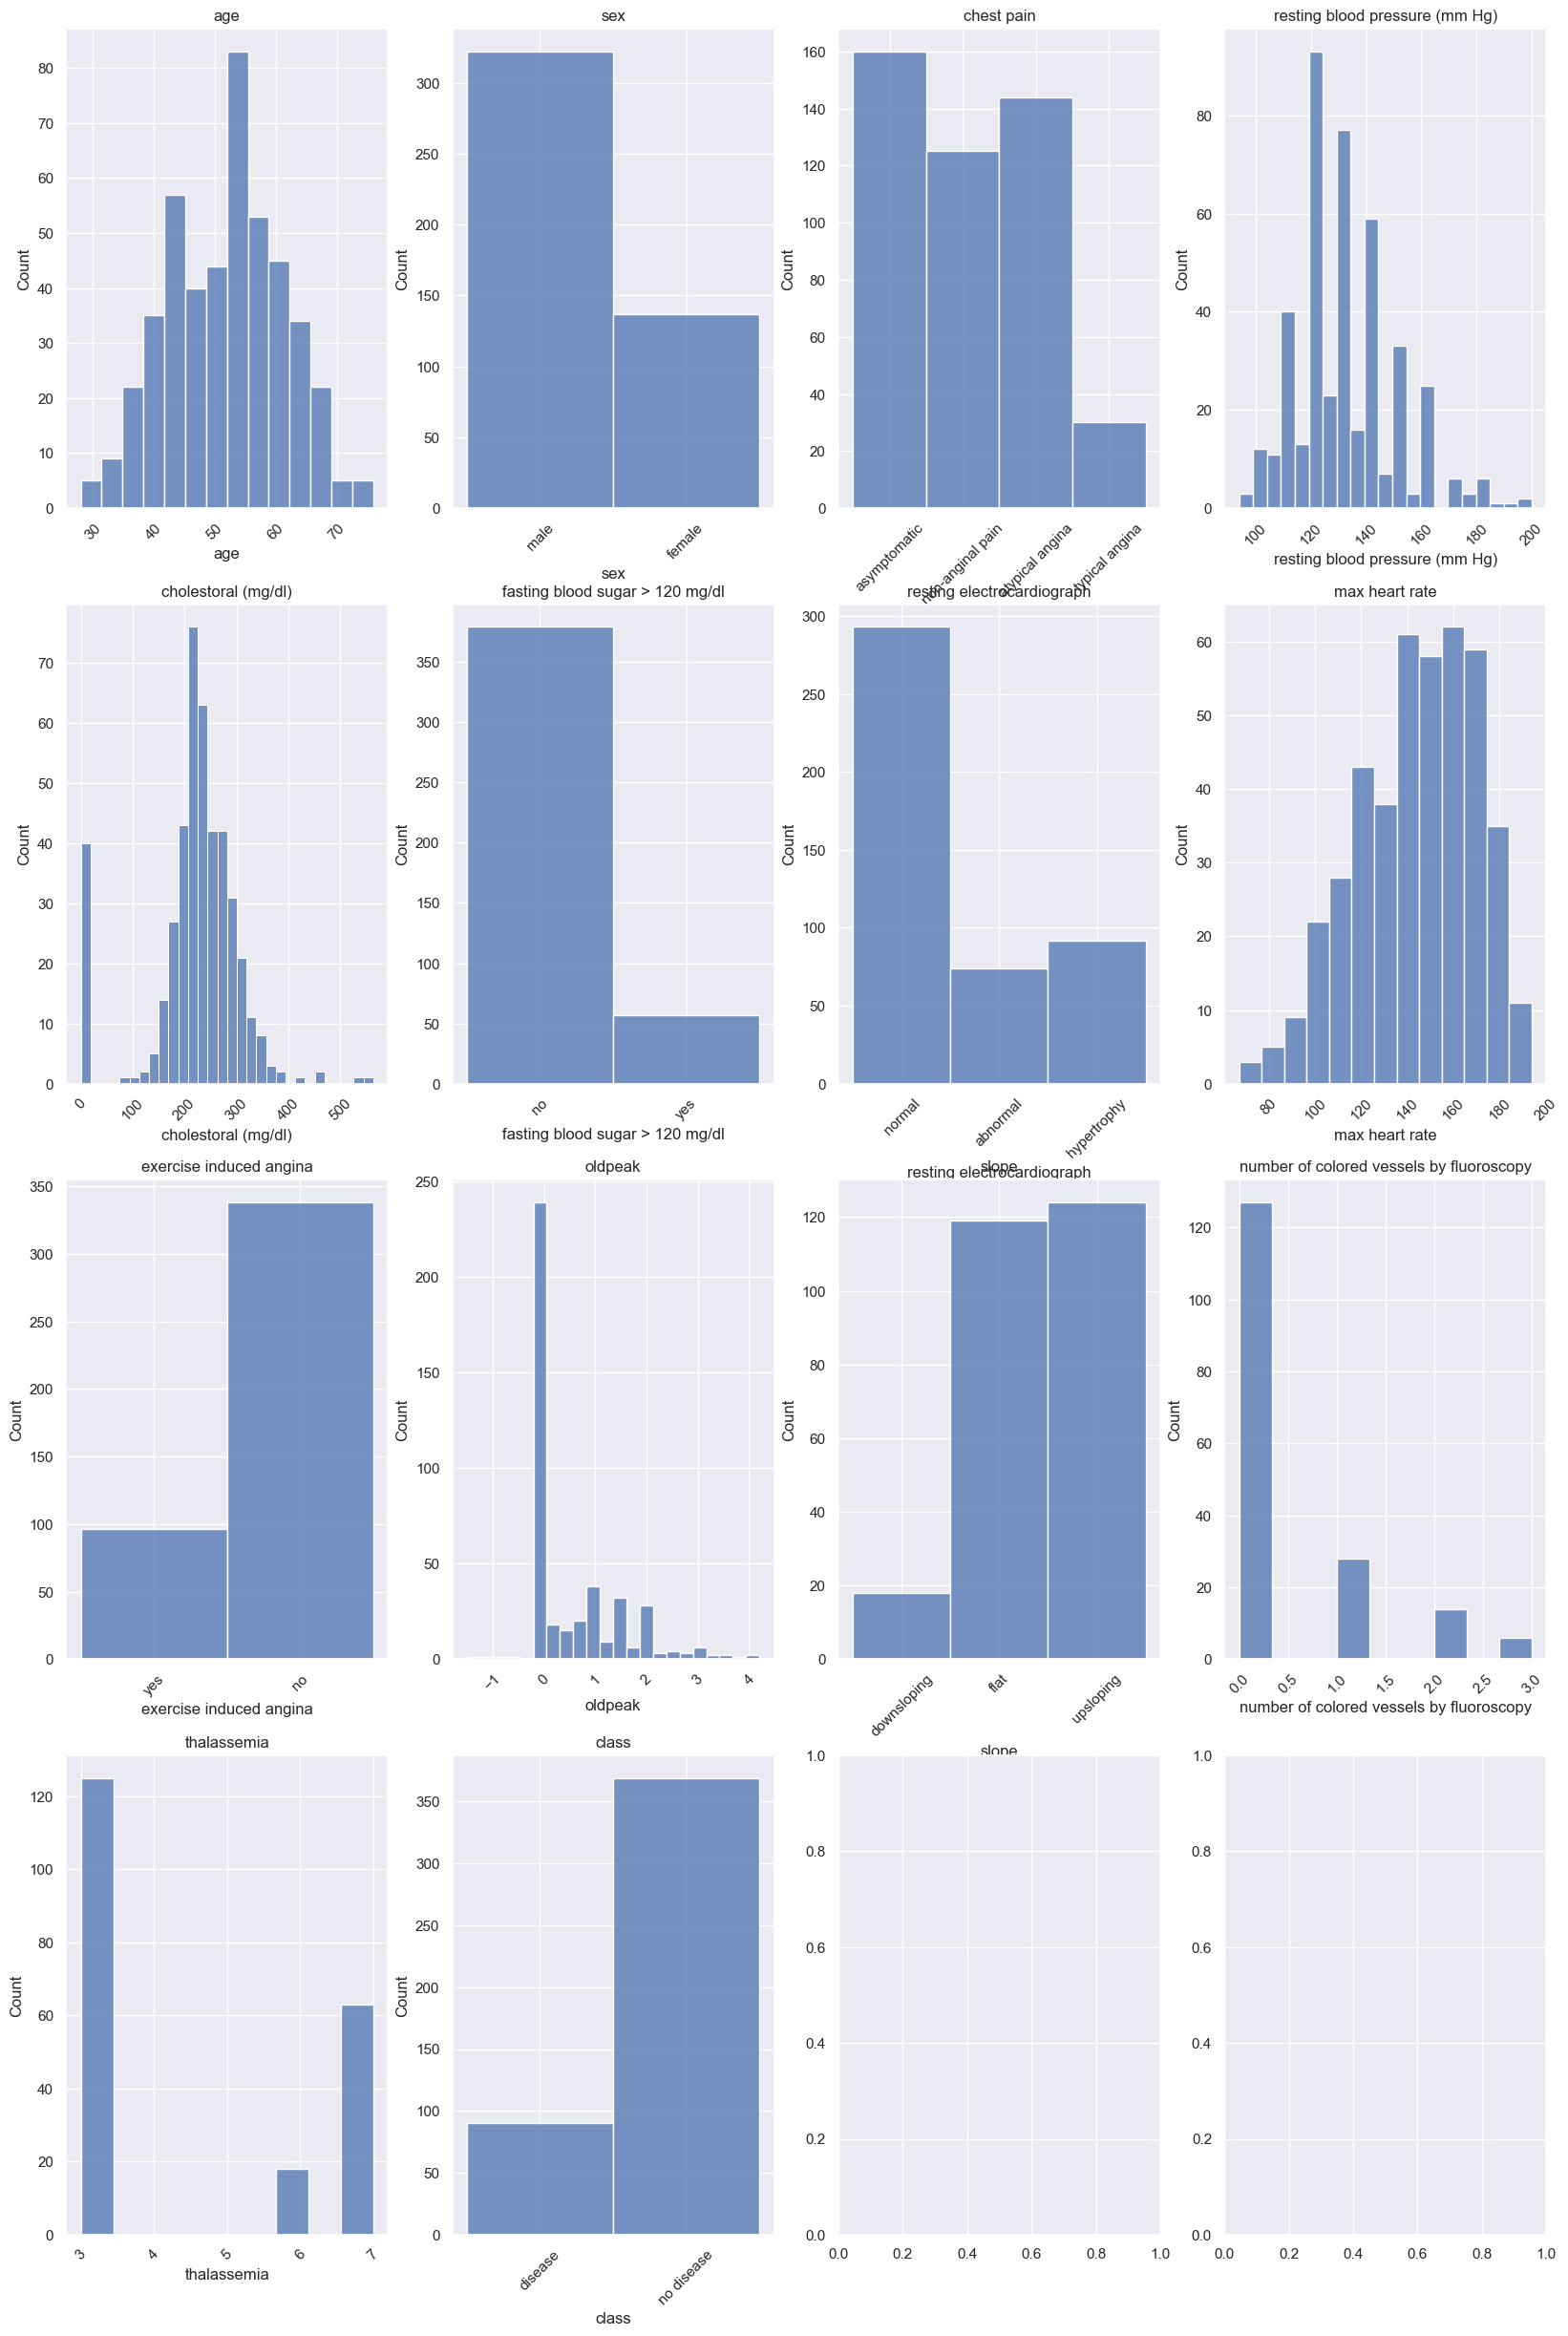

In [178]:
# check number of unique values in each column
# in subplots
fig, axs = plt.subplots(4, 4, figsize=(20, 30))
for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax=axs[i//4, i%4])
    axs[i//4, i%4].set_title(col)
    axs[i//4, i%4].xaxis.set_tick_params(rotation=45)
plt.show()

Q3. Séparez vos données en `df_train` + `df_test`. Vous êtes libre de choisir la proportion de données dans chaque jeu.

In [179]:
# On a peut de données donc on va faire un séparation 80/20
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

Q3. On veut préparer les données de manière à ce qu'elles soient utilisables par un algorithme de ML. Il existe plusieurs façons de les préparer, comme on l'a vu au TP2 (c'est subjectif !). Chaque façon peut donner des performances différentes ; certains algorithmes fonctionneront mieux avec certaines façons que d'autres...

Implémentez la fonction `prepare_data_v1(df)` qui prépare les données d'un *DataFrame* en entrée, de manière la plus simple possible : je recommande un **encodage ordinal** pour commencer et pouvoir tester rapidement vos algorithmes. Supprimez les colonnes contenant trop de NAs (>50%) pour simplifier également, ainsi que les lignes contenant au moins 1 NA.

**Attention** : on rappelle que cet encodage fait perdre toute capacité d'interprétation s'il est utilisé sur une variable qui n'a pas de relation d'ordre ! Certains algorithmes auront également de mauvaises performances car ils calculeront une relation statistique qui n'existe pas... Ce n'est pas grave pour cet exercice, cela permet de tester rapidement un algorithme sur nos données.

**Attention²** : Votre fonction devra fonctionner sur des sous-ensembles de données ! En effet, en pratique vous ne connaîtrez pas vos données d'utilisation avant d'avoir déployé votre modèle... Votre fonction de préparation devra donc être appliquée sur les données d'utilisations indépendamment des données de prototypage. Faites particulièrement attention à **l'ordre de vos encodages** ! Si votre fonction encode `normal=1, abnormal=2` dans vos données de prototypage, puis `abnormal=1, normal=2` dans vos données d'utilisation, votre modèle de ML prédira n'importe quoi... Je recommande de faire votre encodage à la main, en utilisant par exemple [`df.replace()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html) pour vous assurer que l'encodage sera **cohérent**.

In [180]:
def prepare_data_v1(df):
    """
    Prepare data for training
    SI plus de 50% de valeurs manquantes, on supprime la colonne
    SI au moins un NA dans la ligne, on supprime la ligne
    
    Encodage ordinal des variables catégorielles
    """
    df = df.dropna(axis=1, thresh=df.shape[0]//2)
    df = df.dropna(axis=0)
    
    ordinal_mapping = {
        "sex": {"male": 0, "female": 1},
        "chest pain": {"typical angina": 0, "atypical angina": 1, "non-anginal pain": 2, "asymptomatic": 3},
        "fasting blood sugar > 120 mg/dl": {"yes": 1, "no": 0},
        "resting electrocardiograph": {"normal": 0, "abnormal": 1, "hypertrophy": 2},
        "exercise induced angina": {"yes": 1, "no": 0},
        "slope": {"upsloping": 0, "flat": 1, "downsloping": 2},
        "class": {"disease": 1, "no disease": 0}
    }
    for col in df.select_dtypes(include='object').columns:
        for k, v in ordinal_mapping[col].items():
            df[col] = df[col].replace(k, v)

    return df

Si vous avez bien séparés vos données et implémenté la fonction de préparation, la prochaine cellule devrait s'exécuter sans problème. Notez bien que les données de test ne sont pas préparées en même temps que les données d'entraînement !

In [181]:
df_train_v1, df_test_v1 = prepare_data_v1(df_train), prepare_data_v1(df_test)

C:\Users\CPE\AppData\Local\Temp\ipykernel_2412\1213613230.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(k, v)
C:\Users\CPE\AppData\Local\Temp\ipykernel_2412\1213613230.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(k, v)


In [190]:
df_train_v1.columns

Index(['age', 'sex', 'chest pain', 'resting blood pressure (mm Hg)',
       'cholestoral (mg/dl)', 'fasting blood sugar > 120 mg/dl',
       'resting electrocardiograph', 'max heart rate',
       'exercise induced angina', 'oldpeak', 'slope', 'class'],
      dtype='object')

Q5. Implémentez la méthode `evaluate_model(df_train, df_test, data_name, model_name, model_class, hyperparameters)`. Cette méthode devra instancier un estimateur (`model_class`) avec les hyperparamètres demandés, l'entraîner sur les données d'entraînement fournies, puis calculer les métriques suivantes sur les données de test fournies :

- F2-score
- Accuracy
- Precision
- Recall

Vous pouvez utiliser les méthodes de Scikit-learn pour ces [métriques](https://scikit-learn.org/stable/api/sklearn.metrics.html) (attention à la classe d'intérêt ! Par défaut, Scikit utilise `1` comme classe d'intérêt, mais vous pouvez en spécifier une autre via l'argument `pos_label`).

Votre fonction devra renvoyer un *DataFrame* contenant les colonnes suivantes :
- ModelName : le nom du modèle utilisé (algorithme)
- Data : le nom de la méthode de préparation des données
- Hyperparamètres : le dictionnaire des hyperparamètres
- RandomSeed : la graine aléatoire utilisée pour instancier et entraîner le modèle
- Score_f2 : la métrique de F2-Score sur les prédictions de test
- Score_precision : la métrique de Precision sur les prédictions de test
- Score_recall : la métrique de Rappel sur les prédictions de test
- Score_accuracy : la métrique d'Accuracy (% de prédictions correctes) sur les prédictions de test
- TrainedEstimator : l'instance du modèle entraînée (pour réutilisation ultérieure si besoin)


On vous donne le squelette de cette fonction, à vous de remplir les trous !

```python
def evaluate_model(df_train, df_test, data_name, model_name, model_class, hyperparameters):
    X_train = # À COMPLÉTER
    Y_train = # À COMPLÉTER
    X_test = # À COMPLÉTER
    Y_test = # À COMPLÉTER

    # On génère une graine aléatoire ... de manière aléatoire :-)
    seed = np.random.randint(0, 2**32 - 1)
    np.random.seed(seed)

    # On instancie l'algorithme avec les hyperparamètres demandés
    # En pratique, si on a par exemple `model_class=LogisticRegression` et
    # # `hyperparameters={ 'n_iter': 100, 'eta0': 0.1 }`, c'est équivalent à faire
    # `LogisticRegression(n_iter=100, eta0=0.1)`
    estimator = model_class(**hyperparameters)

    # À COMPLÉTER : entraînez le modèle !
    
    y_pred = # À COMPLÉTER : calculez les prédictions sur les données de test

    return pd.DataFrame([{
        'ModelName': model_name,
        'Data': data_name,
        'Hyperparameters': hyperparameters,
        'RandomSeed': seed,
        'Score_f2': # À COMPLÉTER
        'Score_precision': # À COMPLÉTER
        'Score_recall': # À COMPLÉTER
        'Score_accuracy': # À COMPLÉTER
        'TrainedEstimator': estimator
    }])
```

In [182]:
def evaluate_model(df_train, df_test, data_name, model_name, model_class, hyperparameters, seed=None):
    from sklearn import metrics
    X_train = df_train.drop(columns=['class'])
    Y_train = df_train['class']
    X_test = df_test.drop(columns=['class'])
    Y_test = df_test['class']

    # On génère une graine aléatoire ... de manière aléatoire :-)
    if seed is None:
        seed = np.random.randint(0, 2**16 - 1)
    np.random.seed(seed)

    # On instancie l'algorithme avec les hyperparamètres demandés
    # En pratique, si on a par exemple `model_class=LogisticRegression` et
    # # `hyperparameters={ 'n_iter': 100, 'eta0': 0.1 }`, c'est équivalent à faire
    # `LogisticRegression(n_iter=100, eta0=0.1)`
    estimator = model_class(**hyperparameters)

    # À COMPLÉTER : entraînez le modèle 
    estimator.fit(X_train, Y_train)
    
    y_pred = estimator.predict(X_test)
    

    return pd.DataFrame([{
        'ModelName': model_name,
        'Data': data_name,
        'Hyperparameters': hyperparameters,
        'RandomSeed': seed,
        'Score_f2': metrics.fbeta_score(Y_test, y_pred, beta=2),
        'Score_precision': metrics.precision_score(Y_test, y_pred),
        'Score_recall': metrics.recall_score(Y_test, y_pred),
        'Score_accuracy': metrics.accuracy_score(Y_test, y_pred),
        'TrainedEstimator': estimator
    }])

Si vous avez bien implémenté la fonction `evaluate_model()` et que vos données sont bien préparées, l'expérimentation ci-dessous devrait fonctionner et vous afficher le résultat d'une Régression Logistique (sur des données préparées "naïvement").

In [183]:
from sklearn.linear_model import LogisticRegression

# `'v1'` réfère à la fonction `prepare_data_v1`
results = evaluate_model(
    df_train_v1,
    df_test_v1,
    'v1',
    'LogisticRegression',
    LogisticRegression,
    {'penalty': None, 'max_iter': 1000},
)

results

,ModelName,Data,Hyperparameters,RandomSeed,Score_f2,Score_precision,Score_recall,Score_accuracy,TrainedEstimator
0,LogisticRegression,v1,"{'penalty': None, 'max_iter': 1000}",64656,0.597015,0.533333,0.615385,0.744681,"LogisticRegression(max_iter=1000, penalty=None)"


Q6. Enregistrez les résultats de l'expérimentation ci-dessus dans un fichier `models_results.csv`.

On vous donne, pour vous aider, une fonction qui ajoute automatiquement les résultats sans effacer les précédents ! :-)

Note : il est très important d'enregistrer vos résultats à chaque expérimentation, pour ne pas "perdre" ces résultats, en particulier si vous redémarrez votre notebook. Dans la suite du TP, utilisez cette fonction **chaque fois** que vous faites une nouvelle expérimentation ! En pratique, on utilise souvent des outils dédiés tels que ceux présentés en cours (MLFlow, Weights and Biases, Aimstack, ...).

Le fichier `models_results.csv` sera à rendre.

In [184]:
def append_results(results):
    with open('models_results.csv', 'a') as f:
        # Quand le fichier est vide, il faut préciser les colonnes ;
        # si on a au moins une ligne, il ne faut pas répéter les noms des colonnes...
        header = f.seek(0, 2) == 0
        # On ne veut pas écrire la colonne `TrainedEstimator` (c'est un objet Python !)
        columns = [
            'ModelName', 'Data', 'Hyperparameters', 'RandomSeed', 'Score_f2', 
            'Score_precision', 'Score_recall', 'Score_accuracy',
        ]
        results.to_csv(f, header=header, columns=columns, index=False)

In [185]:
append_results(results)

Q7. Pour vous montrer ce qu'on attend pour les prédictions à rendre, faites les prédictions sur le modèle de Régression Logistique de la précédente expérimentation, sur les données "de déploiement", préparées via la façon 'v1'.

On vous fournit une fonction pour écrire les prédictions dans un fichier `predictions.csv`.

**Attention** : dans la suite du TP, vous ne devrez faire les prédictions sur ces données de déploiement que pour votre meilleur modèle et votre meilleure préparation de données ! De toute façon vous n'aurez pas les labels, donc vous ne saurez pas si vos prédictions sont bonnes ou non...

1. Récupérez le modèle entraîné (`TrainedEstimator`) de votre meilleure expérimentation (pour l'instant vous n'en avez qu'une seule : `results`). Si vous redémarrez le notebook d'ici la fin du TP, vous devriez avoir toutes les informations dans le fichier `models_results.csv` (la classe à utiliser, la fonction de préparation de données, les hyperparamètres, et la *seed* aléatoire) pour ré-entraîner le même modèle.
2. Puis, appelez la fonction `write_predictions()` avec en paramètre votre fonction de préparation de données (ici, `prepare_data_v1`) et votre modèle entraîné.

Cette fonction se charge automatiquement de lire les données, les préparer, faire les prédictions, et les écrire dans le fichier de sortie `predictions.csv`. Elle gère également les prédictions manquantes si votre fonction de préparations de données supprime des lignes (NAs).

Le fichier `predictions.csv` sera à rendre.

In [191]:
def write_predictions(prepare_data_function, estimator):
    df_deployment = pd.read_csv('data_deployment.csv', na_values=['?'])
    df_deployment = df_deployment.drop(columns=['thalassemia'])
    df_deployment_prepared = prepare_data_function(df_deployment)
    # /!\ Si la fonction de préparation des données supprime des lignes
    # (par exemple à cause de la gestion des NAs), on va se retrouver 
    # avec moins de prédictions qu'on a de lignes...
    # On doit matcher chaque prédiction avec sa ligne correspondante
    handled_lines = df_deployment_prepared.index

    # On prédit pour chaque ligne des données préparées
    predictions = estimator.predict(df_deployment_prepared)
    # On ré-assimile aux numéros de lignes des données originales
    predictions = pd.Series(predictions, index=handled_lines)

    # On ajoute la colonne aux données originales ; puisqu'on a indexé les
    # prédictions, les prédictions manquantes seront automatiquement remplacées par NaN
    df_deployment['predictions'] = predictions
    # On écrit le fichier
    df_deployment.to_csv('predictions.csv', index=True)

In [192]:
write_predictions(prepare_data_v1, results['TrainedEstimator'].iloc[0])

C:\Users\CPE\AppData\Local\Temp\ipykernel_2412\1213613230.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(k, v)


## Exercice 2 : à vous de jouer !

Vous êtes maintenant libres de vos choix pour identifier le meilleur modèle et la meilleure préparation de données !

N'oubliez pas d'enregistrer chaque expérimentation via la méthode `append_results()`.

**Attention** : une fois que vous avez expérimenté avec une façon de préparer de vos données (par exemple, `prepare_data_v1()`), vous NE DEVEZ PLUS modifier cette fonction ! Sinon, vous rendez irreproductibles toutes vos expérimentations précédentes ! Dans la pratique, on utilise souvent des Data Version Control (DVC) et des Version Control System (VCS, exemple : Git) pour s'assurer de mémoriser ce qu'on a fait et de pouvoir y revenir.

Vous devrez donc implémenter des fonctions `prepare_data_v2()`, `prepare_data_v3()`, etc. (autant que nécessaires pour tester toutes vos idées) !

On vous donne quelques pistes d'exploration ci-dessous pour vous aider ...
Les questions suivantes sont données à titre d'indication, vous n'êtes pas obligés de toutes les faire, ni de suivre cet ordre.

Q1. Faites une EDA plus poussée. Quelles sont les données catégorielles ? Quelles valeurs peuvent-elles prendre ? Existe-t-il des données manquantes ?

Astuce : les types de données que Pandas vous retourne peuvent ne pas être cohérents ! Vérifiez avec la description des données fournie pour détecter si des colonnes devraient plutôt avoir un autre type.

Q2. L'encodage ordinal est un moyen rapide de tester un algorithme (prototypage), mais qui montre vite ses limites, surtout pour les données sans relation d'ordre. Quels autres encodages pouvez-vous utiliser ?

Astuce : il vaut peut-être le coup d'essayer plusieurs formes d'encodages pour voir l'impact sur les performances...

On rappelle quelques méthodes d'encodage :

- Encodage ordinal
- Encodage one-hot
- Encodage binaire

Q3. Quelles sont les échelles de chaque colonne numérique (valeurs min vs max) ? Quelles sont les distributions de ces colonnes ? Quelles normalisations pouvez-vous utiliser ?

Astuce : il vaut peut-être le coup d'essayer plusieurs formes de normalisations pour voir l'impact sur les performances...

On rappelle quelques méthodes de normalisation :
- Linéaire (min-max)
- Z-score
- Log

Vous pouvez utiliser du *clipping* en plus de chacune des méthodes de normalisation.

Q4. Existe-t-il des données manquantes ? Quelles colonnes ont beaucoup de données manquantes ? Combien de lignes possèdent au moins une valeur manquante ?

**Attention** : si votre fonction de préparation de données supprime les lignes contenant 1 valeur manquante (NA), vous allez supprimer des lignes du jeu de données "de déploiement" (ou d'utilisation). Ce qui veut dire que vous ne ferez pas de prédictions sur ces lignes, ce qui baissera forcément votre score ! Durant la phase d'entraînement, on peut se permettre de supprimer les valeurs manquantes si on pense qu'elles vont empêcher l'apprentissage ; mais, en déploiement, quand votre modèle sera utilisé par des personnes extérieures, vous pouvez difficilement vous permettre de rejeter des entrées... (Ou alors, vous risquez que vos utilisateurs finissent par ne plus utiliser votre modèle)

Vous pouvez essayer de supprimer les données manquantes, ou de les remplacer...

On rappelle quelques méthodes de remplacement :
- Par un valeur "sentinelle" indiquant une absence (par exemple, `-1`)
- Par moyenne, médiane, ou mode (valeur fixe)
- Par *forward-fill* ou *backward-fill*
- Par apprentissage non-supervisé

Les méthodes par valeur fixe (moyenne, médiane, mode) ou par données existantes (forward-fill, backward-fill) peuvent être utilisées en corrélation avec d'autres colonnes, par exemple en faisant un `groupby`.

Q5. On a essayé une Régression Logistique, mais il existe d'autres algorithmes de classification ! Lesquels paraissent intéressants pour cette tâche ?
Comparez ces algorithmes, sur vos différentes façons de préparer vos données.

Q6. Chaque algorithme possède un certain nombre d'hyperparamètres, impactant les performances. Comparez les performances de différents hyperparamètres, pour chaque modèle.

La documentation de Scikit-learn liste les hyperparamètres dans le constructeur de chaque algorithme. Attention : cette liste est souvent plus étoffée que celle vue en cours, car Scikit propose des optimisations, mais laisse la configuration de ces optimisations au choix des utilisateurs...

Q7. Quelle est la fréquence de chaque classe ? Vous pouvez essayer de ré-équilibrer les données pour améliorer les performances.

On rappelle quelques méthodes de ré-équilibrage :
- *Downsampling* : diminution de la classe majoritaire jusqu'à atteindre la même proportion que la classe minoritaire.
- *Upsampling* : répétition des individus de la classe minoritaire jusqu'à atteindre la même proportion que la classe majoritaire.
- *Loss weighting* : on peut pondérer la fonction de *loss* pour rendre les erreurs sur la classe minoritaire plus coûteuses. Attention : cela suppose que la distribution des classes dans les données d'utilisation seront les mêmes ! Dans la pratique, vous ne pouvez pas en être certains...
- Génération de données : on peut générer des données similaires aux données existantes, en espérent qu'elles soient suffisamment proches pour qu'elles représentent bien le phénomène que l'on cherche à modéliser. Attention : dans la pratique, c'est compliqué de générer des données pour modéliser un phénomène, sans avoir un modèle du phénomène ...

Q7. Dans la fonction `evaluate_model()`, on vous fait initialement mesurer les performances de votre modèle sur les données de test. Or, en comparant les modèles sur ces données, on risque de choisir un modèle qui est trop spécialisé sur ces données, mais qui ne saura pas généraliser aux données d'utilisation ! On a vu en cours une technique pour éviter ce problème : la *cross-validation*. Vous pouvez implémenter une autre fonction `evaluate_model_cv()` qui suit le même principe mais qui utilise la *cross-validation* pour comparer les modèles.

Astuce : votre fonction peut évaluer plusieurs modèles et retourner un *DataFrame* contenant plusieurs résultats, avec `pd.DataFrame([ {...}, {...}, {...} ])`, où chaque `{...}` est un dictionnaire comme celui de la fonction `evalute_model()`. Cela permettrait d'évaluer les modèles sur les mêmes *folds* de la *cross-validation*.

Q8. Vous pouvez essayer des méthodes ensemblistes.

On rappelle les 3 principales catégories de méthodes ensemblistes vues en cours :
- *Bagging*
- *Boosting*
- *Stacking*

## N'oubliez pas de mettre à jour vos fichiers `models_results.csv` et `predictions.csv` !!!

- `models_results.csv` à chaque expérimentation effectuée ;
- et `predictions.csv` une fois votre meilleur modèle identifié.

Ces fichiers sont à rendre sur Moodle avec votre fichier `tp4.ipynb`.